In [599]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import ipywidgets as widgets
from IPython.display import display, Markdown, HTML

In [ ]:
def display_grid_search_results(grid, X_test, y_test, label_names):

    # Results DataFrame
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by='mean_test_score', ascending=False)

    # Identify param columns dynamically
    param_cols = [col for col in results_df.columns if col.startswith('param_')]

    # Display top results
    display(Markdown("### Grid Search Results"))
    display_cols = param_cols + ['mean_test_score', 'std_test_score']
    display(results_df[display_cols].style.hide(axis="index"))

    # Only show heatmap if exactly 2 param columns
    if len(param_cols) == 2:
        pivot_table = results_df.pivot(index=param_cols[0], columns=param_cols[1], values='mean_test_score')
        plt.figure(figsize=(5, 4))
        sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
        plt.title("Mean Test Accuracy")
        plt.xlabel(param_cols[1])
        plt.ylabel(param_cols[0])
        plt.tight_layout()
        plt.show()

    # Best model parameters
    best_model_data = grid.best_params_.copy()
    best_model_data['mean_test_score'] = f"{grid.best_score_:.4f}"
    best_model_row_df = pd.DataFrame(best_model_data.items(), columns=['Attribute', 'Value'])

    display(Markdown("### Best Model Parameters"))
    display(best_model_row_df.style.hide(axis="index"))

    # Predictions on test set
    y_pred = grid.predict(X_test)

    # Classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=label_names)
    report_df = pd.DataFrame(report_dict).transpose().round(3)

    display(Markdown("### Classification Report"))
    display(report_df)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=label_names, yticklabels=label_names,
                linewidths=0.5, linecolor='gray', square=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.tight_layout()
    plt.show()

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    display(Markdown(f"### Accuracy on Test Set: `{acc:.4f}`"))


In [654]:

def preprocess_user_input(df):
    df[columns_to_standardize] = standard_scaler.transform(df[columns_to_standardize])
    df[columns_to_normalize] = minmax_scaler.transform(df[columns_to_normalize])
    
    df = pd.get_dummies(df, columns=['Precip Type'])
    
    for col in final_columns:
        if col not in df.columns:
            df[col] = 0
            
    df = df[final_columns]    
    return df


def predict_weather(model, preprocess_fn=preprocess_user_input):
    display(HTML("""
    <style>
    .widget-label {
        text-align: left !important;
        min-width: 160px;
    }
    </style>
    """))

    # Layout and style
    widget_layout = widgets.Layout(width='350px', margin='0 0 10px 0')
    desc_style = {'description_width': 'initial'}

    # Input widgets
    temperature = widgets.FloatText(description='Temperature (C):', layout=widget_layout, style=desc_style)
    wind_speed = widgets.FloatText(description='Wind Speed (km/h):', layout=widget_layout, style=desc_style)
    visibility = widgets.FloatText(description='Visibility (km):', layout=widget_layout, style=desc_style)
    pressure = widgets.FloatText(description='Pressure (millibars):', layout=widget_layout, style=desc_style)
    humidity = widgets.FloatText(description='Humidity:', layout=widget_layout, style=desc_style)
    wind_bearing = widgets.FloatText(description='Wind Bearing (degrees):', layout=widget_layout, style=desc_style)
    precip_type = widgets.Dropdown(options=['None', 'Rain', 'Snow'], description='Precip Type:', layout=widget_layout, style=desc_style)
    date = widgets.DatePicker(description='Date:', layout=widget_layout, style=desc_style)
    

    # Predict button
    button = widgets.Button(description="Predict", layout=widgets.Layout(width='150px'))
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            clear_output()
            try:
                user_date = date.value
                if user_date is None:
                    raise ValueError("Please select a date.")
                
                user_df = pd.DataFrame({
                    "Temperature (C)": [temperature.value],
                    "Wind Speed (km/h)": [wind_speed.value],
                    "Visibility (km)": [visibility.value],
                    "Pressure (millibars)": [pressure.value],
                    "Humidity": [humidity.value],
                    "Wind Bearing (degrees)": [wind_bearing.value],
                    "Precip Type": [precip_type.value],
                    "Month": [user_date.month],
                    "Day": [user_date.day]
                })
                processed = preprocess_fn(user_df)
                pred = model.predict(processed)[0]
                display(HTML(f"<h4>🌤️ Predicted Class: <span style='color:green'>{label_names[pred]}</span></h4>"))
            except Exception as e:
                display(HTML(f"<b style='color:red'>❌ Error: {str(e)}</b>"))


    button.on_click(on_button_clicked)

    # Heading
    heading = widgets.HTML("<h2 style='margin-bottom:10px; margin-left:40px;'>🌦️ Weather Prediction Tool</h2>")

    # Button container for centering
    button_box = widgets.HBox([button], layout=widgets.Layout(margin='0 0 0 100px'))

    # Display all
    display(widgets.VBox([
        heading,
        temperature, wind_speed, visibility, pressure,
        humidity, wind_bearing, precip_type, date,
        button_box,
        output
    ]))

In [601]:
weather_dataset = pd.read_csv('weatherHistory.csv')

# Data Visualization

In [602]:
weather_dataset.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [603]:
weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [604]:
weather_dataset["Precip Type"].value_counts()

Precip Type
rain    85224
snow    10712
Name: count, dtype: int64

In [605]:
weather_dataset["Summary"].value_counts()

Summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Hu

In [606]:
weather_dataset["Temperature (C)"].describe()

count    96453.000000
mean        11.932678
std          9.551546
min        -21.822222
25%          4.688889
50%         12.000000
75%         18.838889
max         39.905556
Name: Temperature (C), dtype: float64

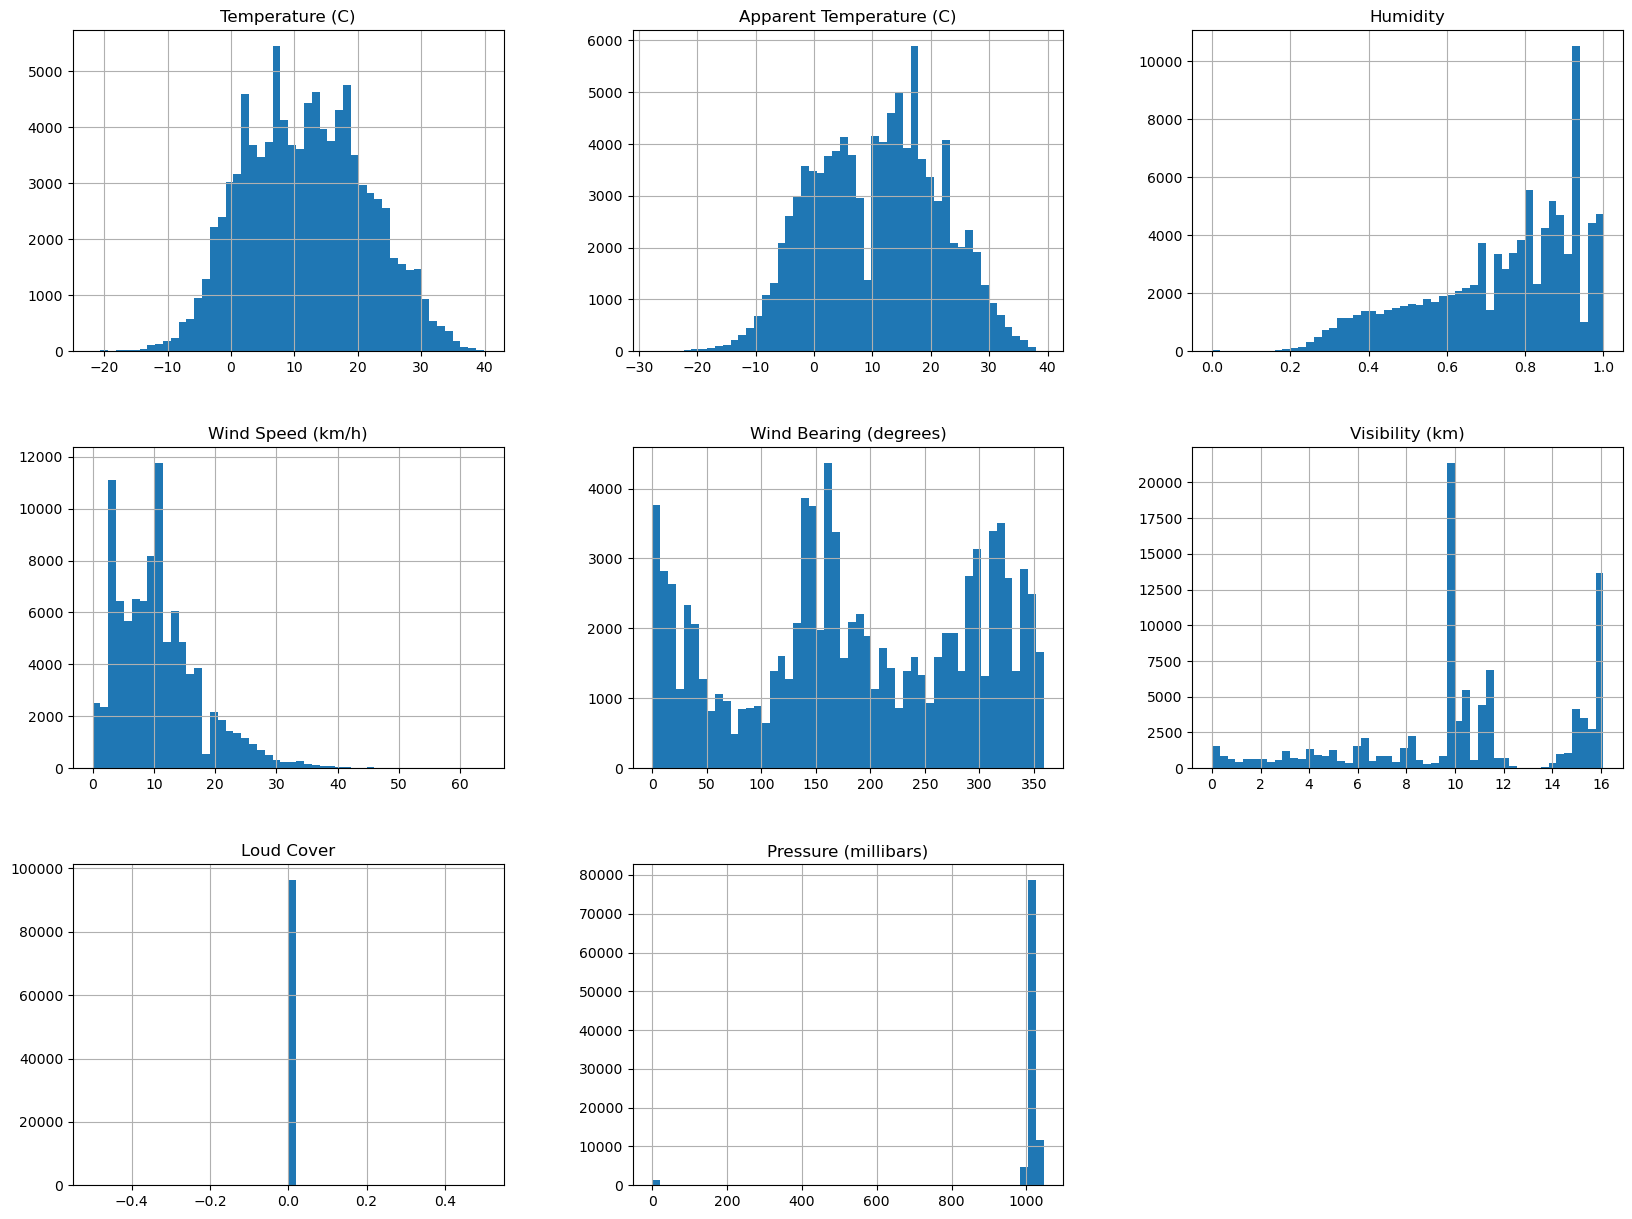

In [607]:
%matplotlib inline
import matplotlib.pyplot as plt
weather_dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [608]:
weather_dataset["Pressure (millibars)"].describe()

count    96453.000000
mean      1003.235956
std        116.969906
min          0.000000
25%       1011.900000
50%       1016.450000
75%       1021.090000
max       1046.380000
Name: Pressure (millibars), dtype: float64

In [609]:
# Replace 0 with NaN or drop the rows
weather_dataset['Pressure (millibars)'] = weather_dataset['Pressure (millibars)'].replace(0, np.nan)

# Then drop NaNs
weather_dataset = weather_dataset.dropna(subset=['Pressure (millibars)'])


# Data Preprocessing

Data Cleaning

In [610]:
top_classes = ['Overcast', 'Clear', 'Foggy']
weather_dataset = weather_dataset[weather_dataset['Summary'].isin(top_classes)]

In [611]:
weather_dataset["Formatted Date"] = pd.to_datetime(weather_dataset["Formatted Date"], utc=True)
weather_dataset["Day"] = weather_dataset["Formatted Date"].dt.day
weather_dataset["Month"] = weather_dataset["Formatted Date"].dt.month
weather_dataset = weather_dataset.drop(["Daily Summary", "Loud Cover", "Formatted Date"], axis=1)

In [612]:
weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33654 entries, 46 to 96436
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Summary                   33654 non-null  object 
 1   Precip Type               33415 non-null  object 
 2   Temperature (C)           33654 non-null  float64
 3   Apparent Temperature (C)  33654 non-null  float64
 4   Humidity                  33654 non-null  float64
 5   Wind Speed (km/h)         33654 non-null  float64
 6   Wind Bearing (degrees)    33654 non-null  float64
 7   Visibility (km)           33654 non-null  float64
 8   Pressure (millibars)      33654 non-null  float64
 9   Day                       33654 non-null  int32  
 10  Month                     33654 non-null  int32  
dtypes: float64(7), int32(2), object(2)
memory usage: 2.8+ MB


Filling Missing Values

In [613]:
# None indicates no precipitation
weather_dataset["Precip Type"] = weather_dataset["Precip Type"].fillna("None")


Encoding

In [614]:
# Apply one hot encoding to prec type
weather_dataset = pd.get_dummies(weather_dataset, columns=["Precip Type"])

In [615]:
label_encoder = LabelEncoder()
weather_dataset["Summary"] = label_encoder.fit_transform(weather_dataset["Summary"])
label_names = label_encoder.classes_

for i, label in enumerate(label_names):
    print(f"{i}: {label}")

0: Clear
1: Foggy
2: Overcast


In [616]:
weather_dataset["Summary"].value_counts()

Summary
2    16442
0    10162
1     7050
Name: count, dtype: int64

Checking For Multicollinearity

In [617]:
weather_dataset.corr().style.background_gradient(cmap='coolwarm')

,Summary,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Day,Month,Precip Type_None,Precip Type_rain,Precip Type_snow
Summary,1.000000,-0.181860,-0.198901,0.240737,0.308217,0.027025,-0.130770,-0.251110,-0.020515,-0.080894,-0.036879,0.004035,0.003618
Temperature (C),-0.181860,1.000000,0.988533,-0.503649,0.033853,0.017120,0.460036,-0.341952,-0.004790,0.161644,0.007632,0.633115,-0.642834
Apparent Temperature (C),-0.198901,0.988533,1.000000,-0.470546,-0.070909,0.020224,0.434700,-0.300970,-0.000084,0.178542,0.008424,0.624933,-0.634713
Humidity,0.240737,-0.503649,-0.470546,1.000000,-0.191818,0.049006,-0.502739,0.020052,0.006160,0.067534,-0.023370,-0.179775,0.186964
Wind Speed (km/h),0.308217,0.033853,-0.070909,-0.191818,1.000000,0.046999,0.170379,-0.331591,-0.033302,-0.127397,0.005211,0.085604,-0.087791
Wind Bearing (degrees),0.027025,0.017120,0.020224,0.049006,0.046999,1.000000,0.033909,-0.067472,-0.008332,-0.005810,0.001762,0.027808,-0.028533
Visibility (km),-0.130770,0.460036,0.434700,-0.502739,0.170379,0.033909,1.000000,-0.188414,-0.040312,-0.083146,-0.052623,0.329072,-0.322302
Pressure (millibars),-0.251110,-0.341952,-0.300970,0.020052,-0.331591,-0.067472,-0.188414,1.000000,0.068353,0.166008,0.030469,-0.339731,0.337726
Day,-0.020515,-0.004790,-0.000084,0.006160,-0.033302,-0.008332,-0.040312,0.068353,1.000000,0.055413,0.057914,-0.029784,0.018067
Month,-0.080894,0.161644,0.178542,0.067534,-0.127397,-0.005810,-0.083146,0.166008,0.055413,1.000000,0.057469,0.140664,-0.154475


In [618]:
weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33654 entries, 46 to 96436
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Summary                   33654 non-null  int32  
 1   Temperature (C)           33654 non-null  float64
 2   Apparent Temperature (C)  33654 non-null  float64
 3   Humidity                  33654 non-null  float64
 4   Wind Speed (km/h)         33654 non-null  float64
 5   Wind Bearing (degrees)    33654 non-null  float64
 6   Visibility (km)           33654 non-null  float64
 7   Pressure (millibars)      33654 non-null  float64
 8   Day                       33654 non-null  int32  
 9   Month                     33654 non-null  int32  
 10  Precip Type_None          33654 non-null  bool   
 11  Precip Type_rain          33654 non-null  bool   
 12  Precip Type_snow          33654 non-null  bool   
dtypes: bool(3), float64(7), int32(3)
memory usage: 2.5 MB


In [619]:
# dropping apparent temperature due to high correlation with temperature
weather_dataset = weather_dataset.drop(["Apparent Temperature (C)"], axis=1)

Splitting the data

In [ ]:
X = weather_dataset.drop(["Summary"], axis=1)
y = weather_dataset["Summary"]

final_columns = X.columns.tolist()

In [586]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Calculate VIF for each feature
# vif = pd.DataFrame()
# vif["feature"] = X.columns
# vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif = vif.sort_values(by="VIF", ascending=False)

# print(vif)

# Non-Parametric Models

## 1. kNN

In [587]:
standard_scaler = StandardScaler()
columns_to_standardize = ["Temperature (C)", "Wind Speed (km/h)", "Pressure (millibars)", "Humidity", "Visibility (km)", "Day", "Month", "Wind Bearing (degrees)"]
X[columns_to_standardize] = standard_scaler.fit_transform(X[columns_to_standardize])

In [588]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, stratify=y)

### Grid Search Results

param_metric,param_n_neighbors,mean_test_score,std_test_score
manhattan,1,0.890354,0.005178
manhattan,3,0.880771,0.002945
manhattan,5,0.874048,0.002866
euclidean,1,0.870445,0.003162
manhattan,2,0.865542,0.000734
euclidean,3,0.860937,0.002738
euclidean,5,0.853062,0.003014
euclidean,2,0.844965,0.001145


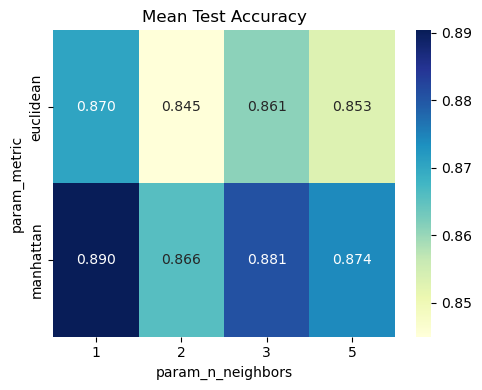

### Best Model Parameters

Attribute,Value
metric,manhattan
n_neighbors,1
mean_test_score,0.8904


### Classification Report

,precision,recall,f1-score,support
Clear,0.894,0.877,0.885,2032.000
Foggy,0.900,0.917,0.909,1410.000
Overcast,0.907,0.910,0.909,3289.000
accuracy,0.902,0.902,0.902,0.902
macro avg,0.900,0.901,0.901,6731.000
weighted avg,0.902,0.902,0.902,6731.000


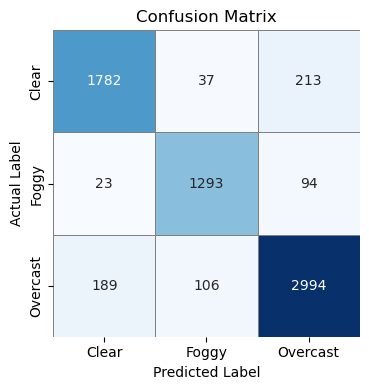

### Accuracy on Test Set: `0.9016`

In [589]:
from sklearn.neighbors import KNeighborsClassifier

# Cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_neighbors': [1, 2, 3, 5],
    'metric': ['euclidean', 'manhattan']
}

# Grid Search
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=skf,
                    scoring='accuracy', n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

# Display results
display_grid_search_results(grid, X_test, y_test, label_names)

In [ ]:
predict_weather(grid)

## 2. Decision Tree

In [556]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Grid Search Results

param_criterion,param_max_depth,mean_test_score,std_test_score
entropy,20,0.875942,0.003464
gini,20,0.869739,0.004422
entropy,15,0.868922,0.002653
gini,15,0.866619,0.005710
gini,10,0.857705,0.006885
entropy,10,0.851985,0.004286


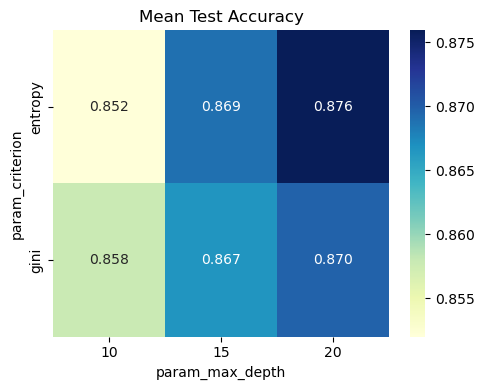

### Best Model Parameters

Attribute,Value
criterion,entropy
max_depth,20
mean_test_score,0.8759


### Classification Report

,precision,recall,f1-score,support
Clear,0.797,0.786,0.791,2033.000
Foggy,1.000,0.997,0.999,1405.000
Overcast,0.869,0.878,0.873,3293.000
accuracy,0.875,0.875,0.875,0.875
macro avg,0.889,0.887,0.888,6731.000
weighted avg,0.875,0.875,0.875,6731.000


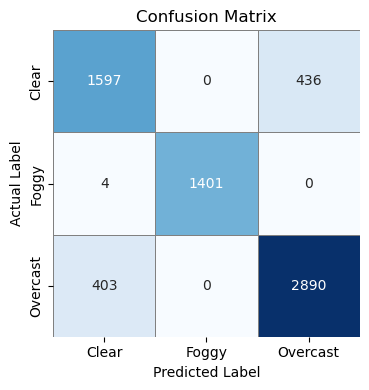

### Accuracy on Test Set: `0.8748`

In [ ]:
from sklearn.tree import DecisionTreeClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20],                   
}

# Setup GridSearchCV
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Display results
display_grid_search_results(grid, X_test, y_test, label_names)

In [656]:
# making a new preprocess function for the decision tree as it doesn't need scaling
def preprocess_user_input_dt(df):
    df = pd.get_dummies(df, columns=['Precip Type'])
    
    for col in final_columns:
        if col not in df.columns:
            df[col] = 0
            
    df = df[final_columns]    
    return df

# Predict weather using the Decision Tree model
predict_weather(grid, preprocess_fn=preprocess_user_input_dt)

## 3. SVM

In [559]:
standard_scaler = StandardScaler()
columns_to_standardize = ["Temperature (C)", "Wind Speed (km/h)", "Pressure (millibars)", "Humidity", "Visibility (km)", "Day", "Month", "Wind Bearing (degrees)"]
X[columns_to_standardize] = standard_scaler.fit_transform(X[columns_to_standardize])

In [560]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Grid Search Results

param_C,param_gamma,mean_test_score,std_test_score
10,scale,0.883891,0.001794
10,0.100000,0.881700,0.002305
1,scale,0.864688,0.002213
1,0.100000,0.863277,0.002410


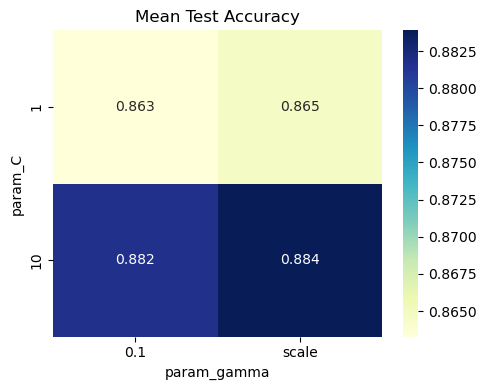

### Best Model Parameters

Attribute,Value
C,10
gamma,scale
mean_test_score,0.8839


### Classification Report

,precision,recall,f1-score,support
Clear,0.838,0.786,0.811,2033.000
Foggy,0.978,0.993,0.986,1405.000
Overcast,0.875,0.903,0.889,3293.000
accuracy,0.886,0.886,0.886,0.886
macro avg,0.897,0.894,0.895,6731.000
weighted avg,0.885,0.886,0.885,6731.000


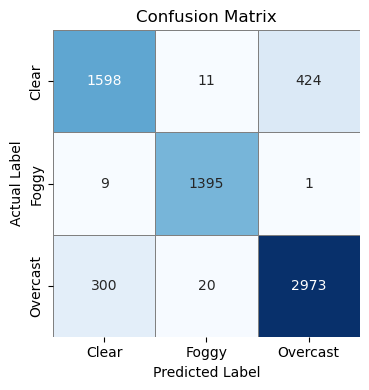

### Accuracy on Test Set: `0.8863`

In [ ]:
from sklearn.svm import SVC

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Simplified parameter grid for multiclass
param_grid = {
    'C': [1, 10],          
    'gamma': ['scale', 0.1]
}

svc = SVC(random_state=42, decision_function_shape='ovr', kernel="rbf")  # 'ovr' for multiclass

# Create grid search with reduced parameters
grid = GridSearchCV(svc, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Display results
display_grid_search_results(grid, X_test, y_test, label_names)


In [657]:
predict_weather(grid)

# Parametric Models

## 1. Logistic Regression

In [627]:
standard_scaler = StandardScaler()
columns_to_standardize = ["Temperature (C)", "Wind Speed (km/h)", "Pressure (millibars)", "Humidity", "Visibility (km)", "Wind Bearing (degrees)", "Day", "Month"]
X[columns_to_standardize] = standard_scaler.fit_transform(X[columns_to_standardize])

In [628]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Grid Search Results

param_C,mean_test_score,std_test_score
1000,0.800430,0.006670
100,0.800393,0.006617
10,0.799650,0.006774
1,0.797162,0.007065
0.100000,0.788805,0.006857


### Best Model Parameters

Attribute,Value
C,1000
mean_test_score,0.8004


### Classification Report

,precision,recall,f1-score,support
Clear,0.690,0.672,0.681,2033.000
Foggy,0.961,0.980,0.970,1405.000
Overcast,0.799,0.805,0.802,3293.000
accuracy,0.801,0.801,0.801,0.801
macro avg,0.817,0.819,0.818,6731.000
weighted avg,0.800,0.801,0.801,6731.000


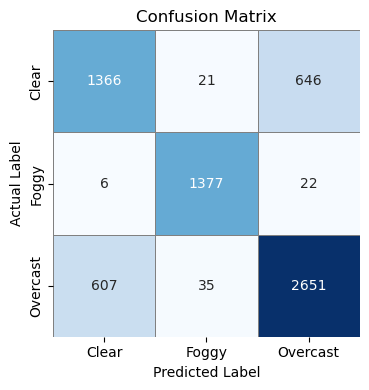

### Accuracy on Test Set: `0.8014`

In [629]:
# import logistic regression
from sklearn.linear_model import LogisticRegression

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}

grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'),
    param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

# Display results
display_grid_search_results(grid, X_test, y_test, label_names)


In [658]:
predict_weather(grid)

# Neural Network

In [630]:
standard_scaler = StandardScaler()
columns_to_standardize = ["Temperature (C)", "Wind Speed (km/h)", "Pressure (millibars)", "Humidity", "Visibility (km)", "Wind Bearing (degrees)", "Day", "Month"]
X[columns_to_standardize] = standard_scaler.fit_transform(X[columns_to_standardize])

In [631]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [643]:
len(X.iloc[0])

11

c:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Model 1 — `[64]`, `relu`, Batch `32`

### Classification Report

,precision,recall,f1-score,support
Clear,0.818,0.788,0.802,2033.000
Foggy,0.996,0.989,0.993,1405.000
Overcast,0.872,0.894,0.883,3293.000
accuracy,0.882,0.882,0.882,0.882
macro avg,0.895,0.890,0.893,6731.000
weighted avg,0.881,0.882,0.881,6731.000


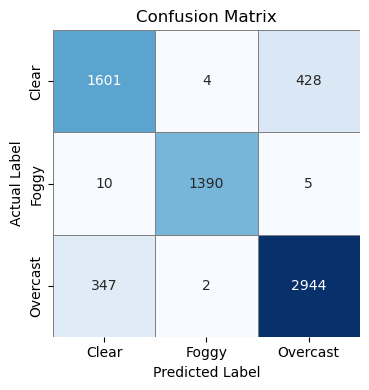

### Accuracy on Test Set: `0.8817`

c:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


## Model 2 — `[32, 16]`, `tanh`, Batch `64`

### Classification Report

,precision,recall,f1-score,support
Clear,0.829,0.758,0.792,2033.000
Foggy,0.993,0.993,0.993,1405.000
Overcast,0.858,0.904,0.880,3293.000
accuracy,0.878,0.878,0.878,0.878
macro avg,0.894,0.885,0.889,6731.000
weighted avg,0.878,0.878,0.877,6731.000


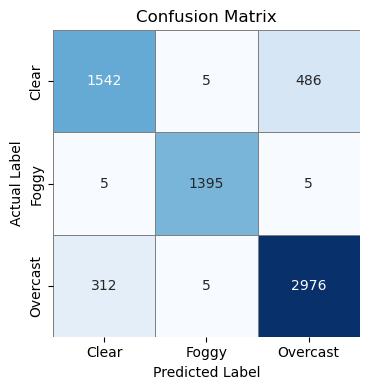

### Accuracy on Test Set: `0.8785`

c:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


## Model 3 — `[64, 64, 32]`, `relu`, Batch `32`

### Classification Report

,precision,recall,f1-score,support
Clear,0.865,0.826,0.845,2033.000
Foggy,0.979,0.992,0.986,1405.000
Overcast,0.895,0.915,0.905,3293.000
accuracy,0.904,0.904,0.904,0.904
macro avg,0.913,0.911,0.912,6731.000
weighted avg,0.904,0.904,0.904,6731.000


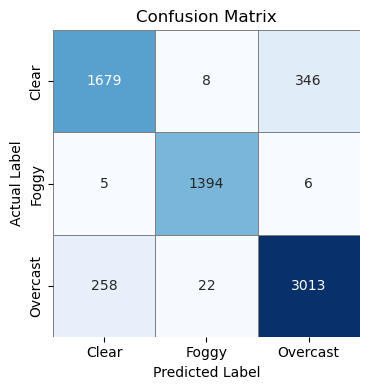

### Accuracy on Test Set: `0.9042`

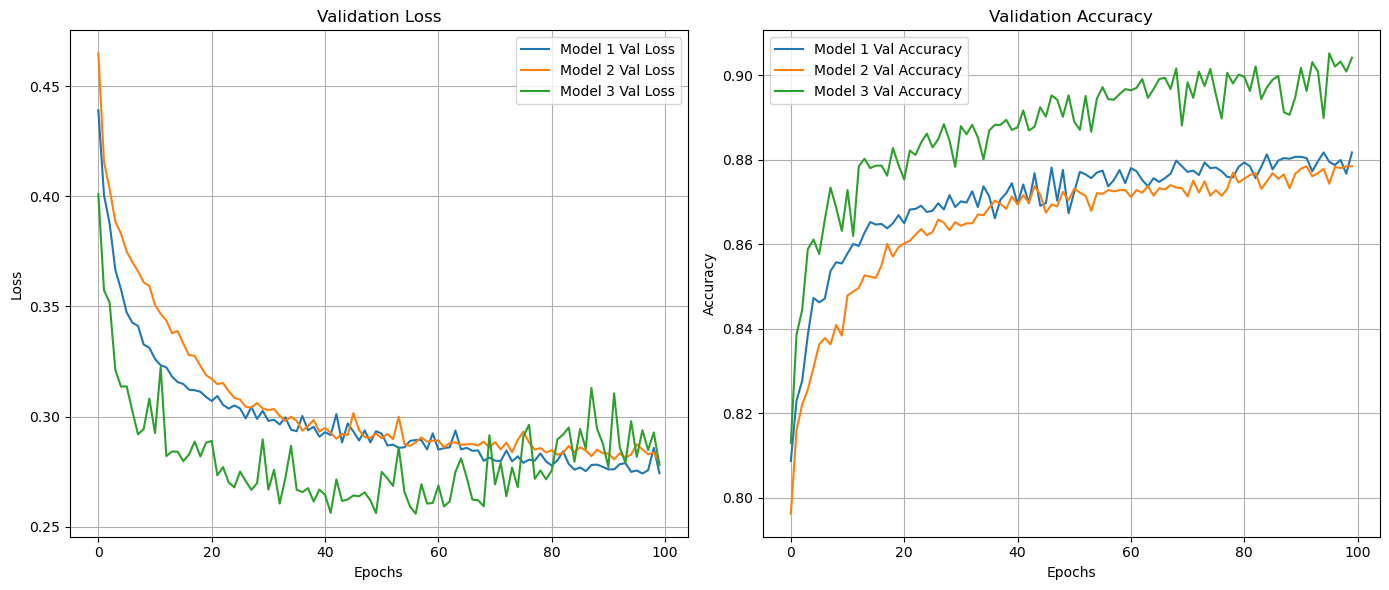

In [652]:
from keras.models import Sequential
from keras import layers

# Define the training function
def train_model(hidden_layers, activation, batch_size, model_name, epochs=100):
    model = Sequential()
    model.add(layers.Dense(hidden_layers[0], activation=activation, input_shape=(X_train.shape[1],)))
    for units in hidden_layers[1:]:
        model.add(layers.Dense(units, activation=activation))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Display results
    display(Markdown(f"## {model_name} — `{hidden_layers}`, `{activation}`, Batch `{batch_size}`"))

    # Classification Report
    report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=label_names)
    report_df = pd.DataFrame(report_dict).transpose().round(3)
    display(Markdown("### Classification Report"))
    display(report_df)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=label_names, yticklabels=label_names,
                linewidths=0.5, linecolor='gray', square=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.tight_layout()
    plt.show()

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    display(Markdown(f"### Accuracy on Test Set: `{acc:.4f}`"))

    return model, history


# Plot training history comparison
def plot_history(histories, labels):
    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label} Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Train models
model1, history1 = train_model(hidden_layers=[64], activation='relu', batch_size=32, model_name='Model 1')
model2, history2 = train_model(hidden_layers=[32, 16], activation='tanh', batch_size=64, model_name='Model 2')
model3, history3 = train_model(hidden_layers=[64, 64, 32], activation='relu', batch_size=32, model_name='Model 3')

# Compare all models' training curves
plot_history(
    [history1, history2, history3],
    ['Model 1', 'Model 2', 'Model 3']
)


In [660]:
# Create Output widgets to capture the UI for each model
tab1_out = widgets.Output()
tab2_out = widgets.Output()
tab3_out = widgets.Output()

with tab1_out:
	predict_weather(model1)
with tab2_out:
	predict_weather(model2)
with tab3_out:
	predict_weather(model3)

# Wrap them in a Tab widget
tabs = widgets.Tab(children=[tab1_out, tab2_out, tab3_out])
tabs.set_title(0, 'Model 1')
tabs.set_title(1, 'Model 2')
tabs.set_title(2, 'Model 3')

# Display the tabs
display(tabs)